In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
import sklearn
import scipy
import statsmodels
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy
import evo_etc
from functools import reduce
import multiprocessing
from copy import deepcopy

In [2]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [3]:
def boot_strap_ci(data,sampling_time=1000):
    # data is a matrix, we are going to get cis for all columns
    data = np.array(data)
    def _ci_of_a_column(lst):
        means = []
        for _ in range(sampling_time):
            sampled_index = np.random.randint(0,len(lst),size=len(lst)) 
            means.append(np.mean(lst[sampled_index]))
        means.sort()
        return [means[24],means[974]]
    
    cis = list()
    for i in range(data.shape[1]):
        cis.append(_ci_of_a_column(data[:,i]))
    
    return np.array(cis)

In [4]:
!less ../data/enzyme_uniprot_gene_name.csv|grep ADE5

P07244,ADE5,7


In [5]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

In [6]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))


def load_pickle_model(filename):
        # This function loads simulated results, but deletes the particles in order to save memory
        model = load_pickle(filename)
        del model.all_particles
        return model
        

def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Load data

In [7]:
model_skeleton = load_pickle("../results/permuted_smcabc_res/simulation_skeleton.pkl")

In [8]:
model_skeleton["model"] = list(map(load_pickle_model,model_skeleton.outfile))

In [9]:
model_frame = model_skeleton.set_index(["origin","status"])

In [13]:
reference_model = model_frame.loc[("unpermuted","original"),"model"]

In [14]:
models = model_frame.model

In [15]:
!pwd

/home/jakobpp/BayesianGEM/code


### Visualize particle population

In [17]:
model_frame["particle_df"] = load_pickle("../results/permuted_smcabc_res/particle_df.pkl")

In [18]:
unique_origins = model_frame.index.get_level_values("origin").unique()

In [19]:
combined_df = load_pickle("../results/permuted_smcabc_res/combined_particle_df.pkl")

In [20]:
pca_ordination = load_pickle("../results/permuted_smcabc_res/pca_full_ordination.pkl")

(63139,)
(61724,)
(62675,)
(62990,)
(63474,)
(62980,)
(62952,)
(63087,)


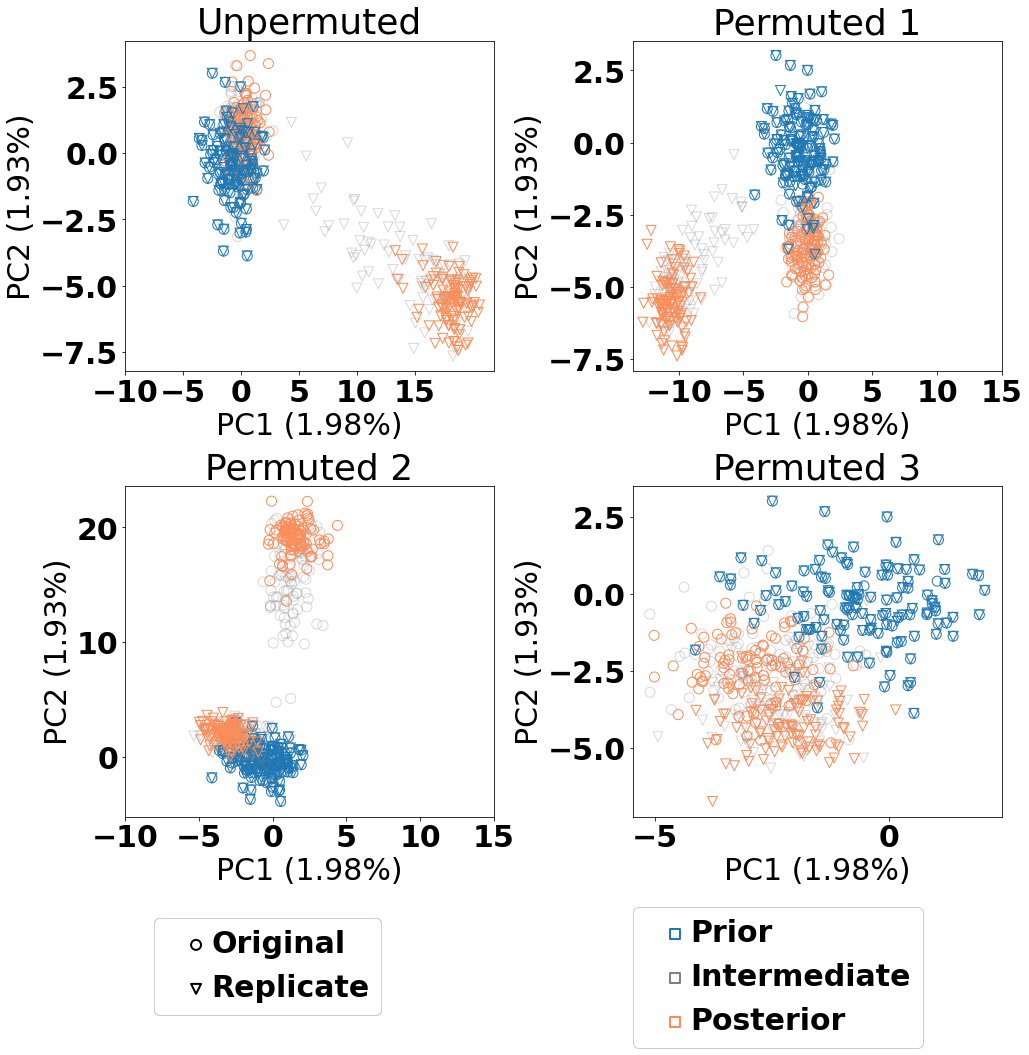

In [166]:
thinning_rng = np.random.default_rng(3052)
i=1
plt.figure(figsize=(15,15))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
marker_dict = {'original': 'o', 'replicate': "v"}
all_periods = ["Prior", "Intermediate", 'Posterior']
period = combined_df["period"].to_numpy()
prior = combined_df["origin"].to_numpy()
model = combined_df["status"].to_numpy()
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
PCS, EV = pca_ordination
for origin in proper_names.keys():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero((model == label) & (prior == origin))[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                    marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.3,label='Intermediate',marker=marker,facecolors='none',s=100)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    i += 1
    plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-10,20,5))
    plt.title(proper_names[origin])
    plt.tight_layout()
colors = ['#1f78b4', 'grey', '#fc8d59']
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none", s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in marker_dict.values()]
legend_period = plt.legend(handles_period, all_periods, loc=(0,-.7), framealpha=1, handletextpad=-.5)
legend_status = plt.legend(handles_model, ["Original", "Replicate"], loc=(-1.3,-.6), framealpha=1,handletextpad=-.5)
plt.gcf().add_artist(legend_period)
plt.gcf().add_artist(legend_status)
plt.gcf().subplots_adjust(bottom=.22)
plt.savefig("../figures/pca.png",dpi=300)
plt.show()

## $R^2$ convergence plots

In [48]:
def r2_on_data(Yobs, simulated_data_one):
    r2_diff_dbs = [r2_score(Yobs[db],simulated_data_one[db]) for db in Yobs]
    return np.mean(r2_diff_dbs)

In [49]:
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}

Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}

In [50]:
def plot_convergence_inner(model, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    # r2s_history = np.array([r2_on_data(Yobs, item) if item is not None else 0 for
    #                         item in model.all_simulated_data[:offset*maxiter]])
    r2s_history = -np.array(model.all_distances[:offset*maxiter])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(model.all_simulated_data):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

In [51]:
def plot_convergence(model, maxiter=100):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter)
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.tight_layout()
    plt.show()

In [52]:
def plot_convergence_and_compare(model, reference_model, maxiter=500, legend = True):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter, label = 'Original')
    plot_convergence_inner(reference_model,maxiter, label = 'Replicate')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend()
    plt.tight_layout()
    plt.show()

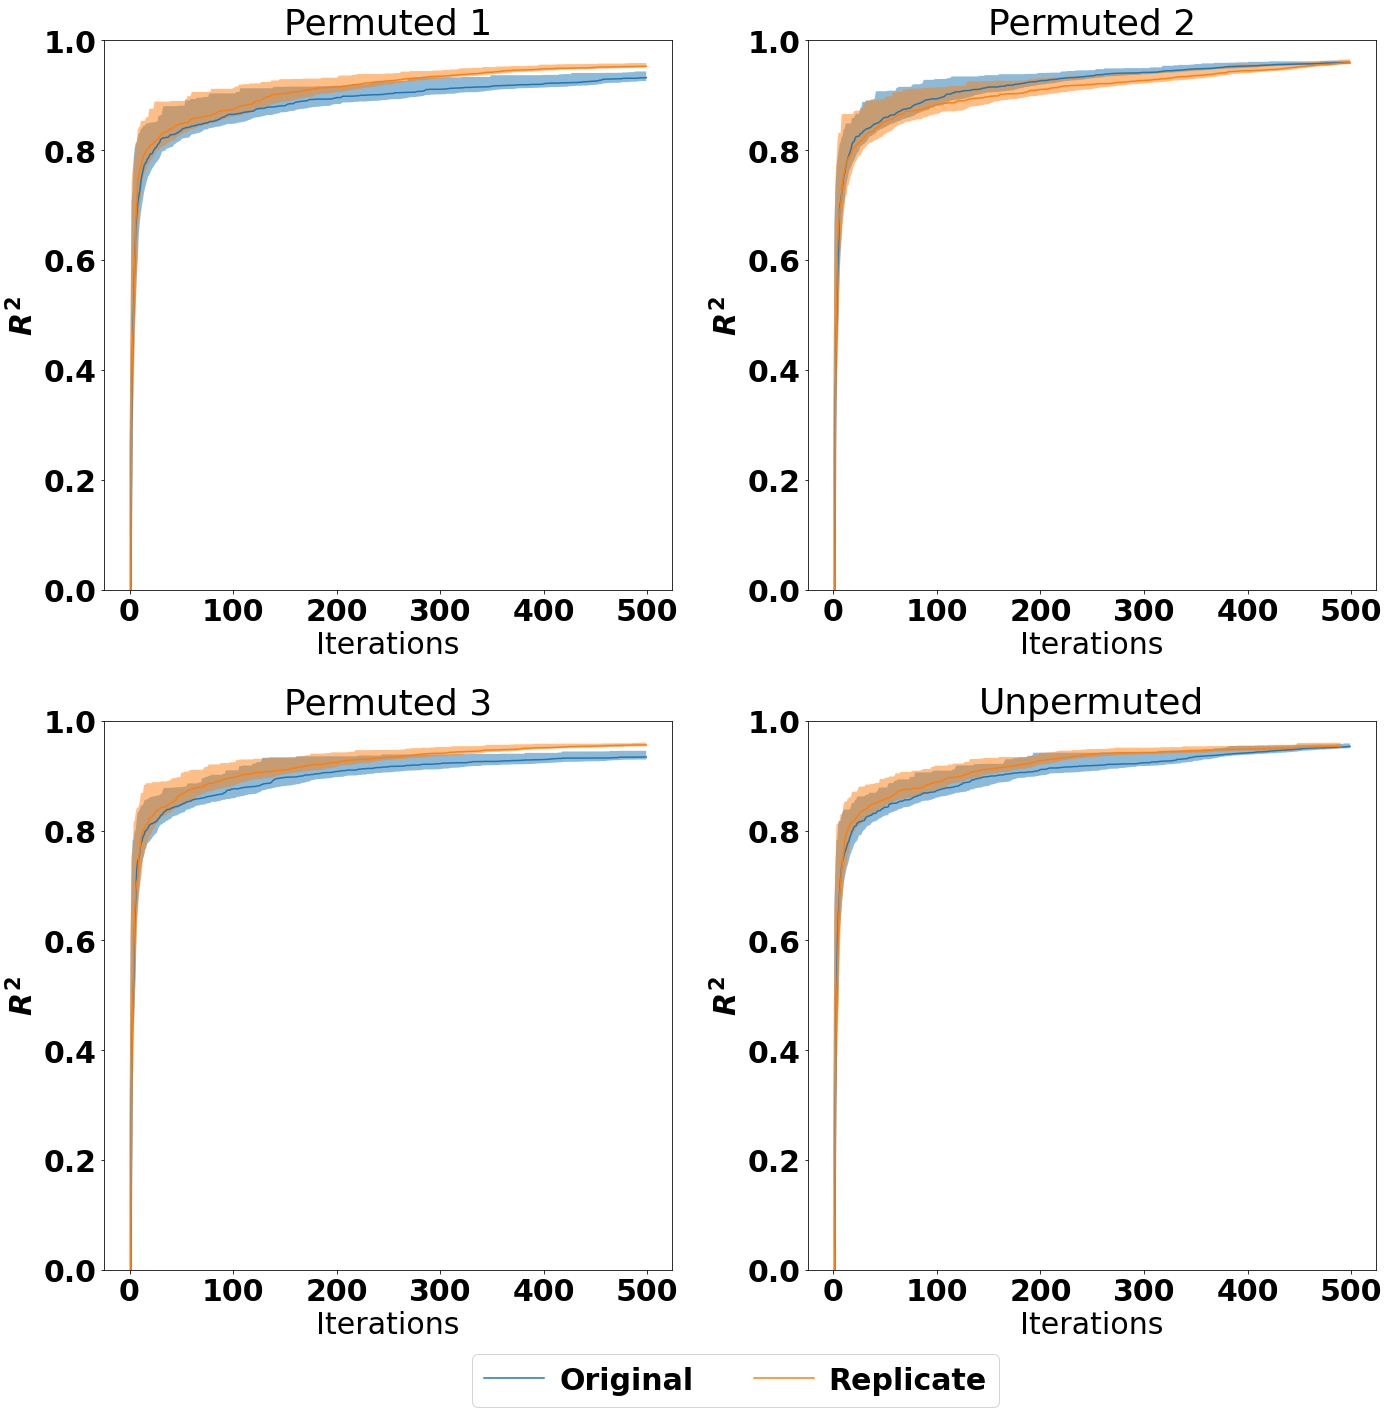

In [85]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1",
                'permuted_1': "Permuted 2", 'permuted_2': "Permuted 3"}
maxiter = 500
i = 1
plt.figure(figsize=(20,20))
for index, series in model_frame["model"].groupby("origin"):
    plt.subplot(2,2,i)
    models = series[index]
    original_model = models["original"]
    replicate_model = models["replicate"]
    plot_convergence_inner(original_model,maxiter, label = 'Original')
    plot_convergence_inner(replicate_model,maxiter, label = 'Replicate')
    if i==4:
        handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.title(proper_names[index])
    i += 1
    plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.gcf().legend(handles,labels, loc=(.34,0.005),ncol=2,handletextpad=0.5)
plt.savefig("../figures/R2.pdf")
plt.show()

# Results of evolutionary algorithm

In [123]:
evolution_model = pickle.load(open('../results/smcevo_gem_three_conditions_save_all_particles_refined.pkl','rb'))

In [124]:
evolution_model.generation_size

100

In [125]:
evolution_model.generations

501

In [126]:
len(evolution_model.population)

100

In [127]:
len(evolution_model.all_particles)

64100

In [128]:
len(evolution_model.all_particles) / evolution_model.generations # 50 new children per generations

127.9441117764471

In [129]:
len(evolution_model.all_particles) % evolution_model.generations

473

In [130]:
evolution_model.generations

501

In [131]:
type(evolution_model.all_particles[0])

dict

In [152]:
def plot_convergence_and_compare_evolution(model, reference_model, maxiter=100, legend = True):
    plot_convergence_inner(model, generation_size=100, maxiter=maxiter, label = 'Evolutionary')
    plot_convergence_inner(reference_model, maxiter=maxiter, label = 'Bayesian')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend(loc="lower right",handletextpad=0.5)
    plt.tight_layout()

In [133]:
evolution_model

In [134]:
reference_model

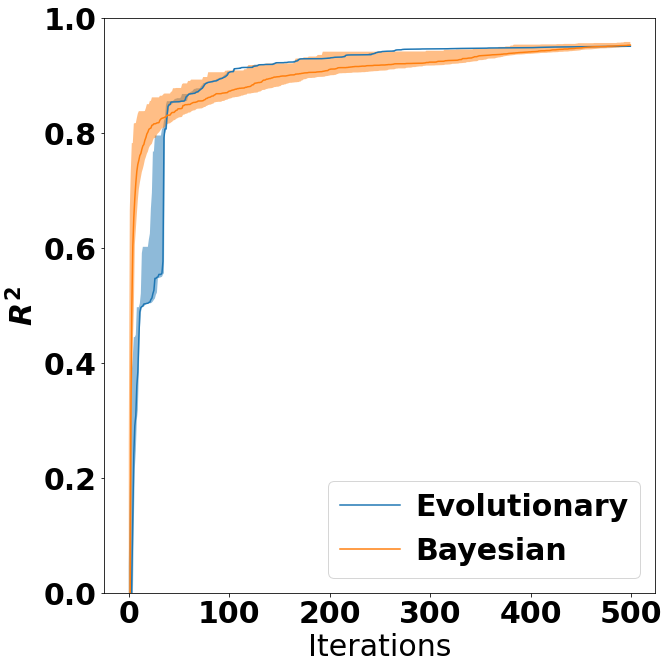

In [153]:
fig = plt.figure(figsize=(10,10))
evo_convergence_figure = plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = 500)
plt.savefig("../figures/evo_fig_full.pdf")

In [135]:
evolution_combined_df = load_pickle("../results/evo_combined_particle_df.pkl")

In [136]:
PCS_evo,EV_evo = load_pickle("../results/evo_pca_full_ordination.pkl")

In [154]:
model = evolution_combined_df.values[:,-1]
period = evolution_combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

In [163]:
markers = ["o","v"]
marker_dict = {'Bayesian': "o", 'Evolutionary': 'v'}
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)

def create_evo_pca_plot(legend = True):
    for label in ["Bayesian","Evolutionary"]:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(this_idxs["Intermediate"])
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        
        this_idxs["Intermediate"] = thinning_rng.choice(this_idxs["Intermediate"],size=100,replace=False)
        this_idxs["Posterior"] = thinning_rng.choice(this_idxs["Posterior"],size=100,replace=False)
        plt.scatter(PCS_evo[this_idxs['Prior'],0],PCS_evo[this_idxs['Prior'], 1],edgecolors='#1f78b4',label='Prior',
                    marker=marker,facecolors='none', s=100)
        plt.scatter(PCS_evo[this_idxs["Intermediate"],0],PCS_evo[this_idxs["Intermediate"], 1],
                    edgecolors='grey',alpha=0.5,label='Intermediate',marker=marker, facecolors='none',s=100)
        plt.scatter(PCS_evo[this_idxs['Posterior'],0],PCS_evo[this_idxs['Posterior'], 1],
                    edgecolors='#fc8d59',label='Posterior',marker=marker, facecolors='none',s=100)
    plt.xlabel('PC1 ({:.2f}%)'.format(EV_evo[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV_evo[1]*100))
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
    plt.xticks(np.arange(-10,50,10))
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels_period = ["Prior", "Intermediate", 'Posterior']
    labels_status = ['Bayesian', "Evolutionary"]
    if legend:
        f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
        handles_period = [f("s", color) for color in colors]
        handles_model = [f(marker, "k") for marker in markers]
        legend_period = plt.legend(handles_period, labels_period, loc=(.5,.1), framealpha=1)
        legend_model = plt.legend(handles_model, labels_status, loc=(.1,.1), framealpha=1)
        plt.gca().add_artist(legend_period)
        plt.gca().add_artist(legend_model)

[  129   130   131 ... 63135 63136 63138]
(63139,)
[ 63232  63233  63234 ... 120317 120321 120325]
(57188,)


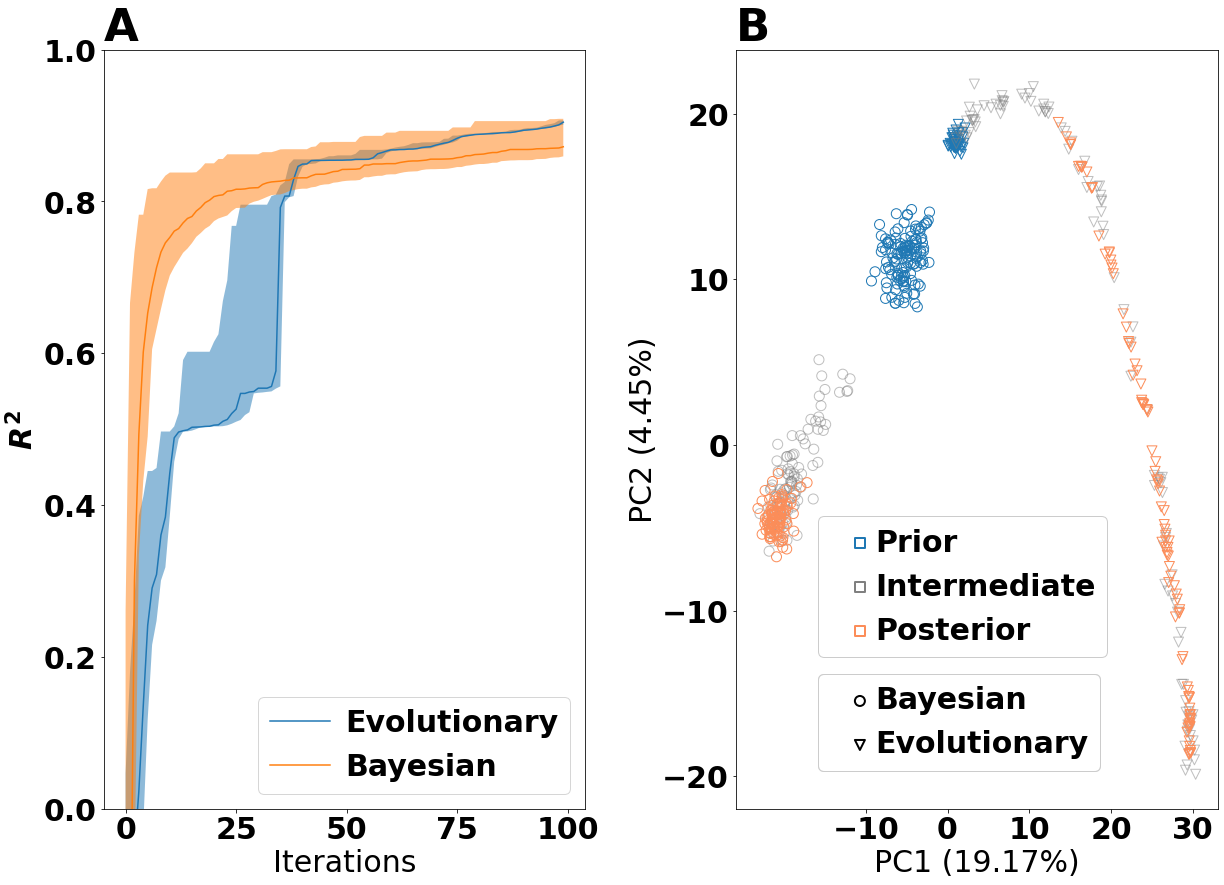

In [164]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
labels_period = ["Prior", "Intermediate", 'Posterior']
labels_status = ['Bayesian', "Evolutionary"]
matplotlib.rc('font', **font)
thinning_rng = np.random.default_rng(5024)
plt.figure(figsize=(18,13))
plt.subplot(1,2,1)
plt.title("A",loc="left",fontsize=45,fontweight="bold")
plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = 100)
plt.subplot(1,2,2)
plt.title("B",loc="left",fontsize=45,fontweight="bold")
create_evo_pca_plot(legend = False)
f = lambda m,c: plt.scatter([],[],marker=m,edgecolors=c, facecolors="none",s=100,linewidth=2)
handles_period = [f("s", color) for color in colors]
handles_model = [f(marker, "k") for marker in markers]
legend_period = plt.legend(handles_period, labels_period, loc=(.17,.20), framealpha=1, handletextpad=-0.5)
legend_model = plt.legend(handles_model, labels_status, loc=(.17,.05), framealpha=1,handletextpad=-0.5)
plt.gca().add_artist(legend_period)
plt.gca().add_artist(legend_model)
plt.savefig("../figures/evo_fig.png",dpi=600,bbox_inches = 'tight')


In [309]:
np.median(-np.sort(reference_model.all_distances)[0:99])

0.9531292853589542

In [310]:
np.median(-np.sort(evolution_model.all_distances)[0:99])

0.9511213513744128

# Effects on pathway level

In [7]:
fva_results = load_pickle("../results/permuted_smcabc_res/fva_at_three_conditions.pkl")

In [8]:
fva_results

,origin,status,particle,fva_res
0,unpermuted,original,"{'O13525_Tm': 331.6638596175288, 'O13525_Topt'...",reaction T minimum m...
1,unpermuted,original,"{'O13525_Tm': 320.8117136606959, 'O13525_Topt'...",reaction T minimum m...
2,unpermuted,original,"{'O13525_Tm': 325.1114607019797, 'O13525_Topt'...",reaction T minimum m...
3,unpermuted,original,"{'O13525_Tm': 328.06580038410783, 'O13525_Topt...",reaction T minimum m...
4,unpermuted,original,"{'O13525_Tm': 332.6392528598742, 'O13525_Topt'...",reaction T minimum m...
...,...,...,...,...
155,permuted_2,replicate,"{'O13525_Tm': 330.1971646826934, 'O13525_Topt'...",reaction T minimum m...
156,permuted_2,replicate,"{'O13525_Tm': 325.3997674288382, 'O13525_Topt'...",reaction T minimum m...
157,permuted_2,replicate,"{'O13525_Tm': 328.0381286580098, 'O13525_Topt'...",reaction T minimum m...
158,permuted_2,replicate,"{'O13525_Tm': 335.41589645137054, 'O13525_Topt...",reaction T minimum m...


In [9]:
fva_results.fva_res[0]

,reaction,T,minimum,maximum,condition
0,r_0006,289.15,0.009610,0.009620,aerobic
1,r_0026,289.15,0.000000,0.000159,aerobic
2,r_0043,289.15,0.000000,-0.000000,aerobic
3,r_0044,289.15,0.000000,-0.000000,aerobic
4,r_0070,289.15,0.000000,-0.000000,aerobic
...,...,...,...,...,...
6738,draw_prot_P00410,311.65,0.000003,0.000003,chemostat
6739,draw_prot_P00420,311.65,0.000002,0.000002,chemostat
6740,draw_prot_P00163,311.65,0.000021,0.000021,chemostat
6741,prot_pool_exchange,311.65,0.089221,0.089330,chemostat


In [12]:
fva_aggregated_res = fva_results.groupby(["origin","status"])

In [13]:
def aggregate_fva_res(res_list):
    return (
    pd.concat(res_list).
    melt(id_vars=["reaction","T", "condition"],value_vars=["minimum","maximum"], var_name="fva_sense", value_name="value").
    replace([np.inf, -np.inf],np.nan).
    dropna(how="all").
    groupby(["condition","reaction","T","fva_sense"]).
    agg(['min','max','var','mean','count']).
    droplevel(level=0,axis=1)
    )

In [14]:
fva_accumulated = (
    fva_aggregated_res.agg(particles = ('particle',list), fva_list = ('fva_res', list)).
    assign(fva_res = lambda df: list(map(aggregate_fva_res,df.fva_list))).
    drop(labels="fva_list", axis=1)
    )
                                                                                              

In [15]:
from itertools import combinations

In [16]:
comparsion_combinations = list(combinations(fva_accumulated.index,2))

In [17]:
data_series = fva_accumulated["fva_res"]
tol = 1e-2
std_threshold = 2
def compare_fva_results(combination):
    x = data_series[combination[0]]
    y = data_series[combination[1]]
    pairs_to_pick = set(x.index).intersection(y.index)
    x_sub = x.loc[pairs_to_pick]
    y_sub = y.loc[pairs_to_pick]
    entries_significantly_different = (x_sub["mean"] - y_sub["mean"]).abs() > tol + std_threshold*np.sqrt(x_sub["var"] + y_sub["var"])
    # This is in order to remove reactions which constitute infinte loops and creates nonsense results
    entries_with_enough_support = (x_sub["count"] > 10) & (y_sub["count"] > 10) & (x_sub["max"] < 100) & (y_sub["max"] < 100)
    subscript_vector = entries_significantly_different & entries_with_enough_support
    return pd.merge(x_sub[subscript_vector], y_sub[subscript_vector], left_index=True, right_index=True)

In [18]:
fva_comparisions = pd.Series({combination: compare_fva_results(combination) for combination in comparsion_combinations})

In [340]:
fva_comparisions[1]

min_x      max_x     var_x  \
condition reaction       T      fva_sense                                  
aerobic   arm_r_0486_REV 295.15 maximum    0.051926   0.109798  0.000178   
          r_0486_REVNo1  299.15 maximum    0.078299   0.109374  0.000124   
          arm_r_0486_REV 289.15 maximum    0.019260   0.109089  0.000548   
anaerobic r_0486_REVNo1  299.45 maximum    0.077456   0.109119  0.000115   
chemostat r_0962No1      311.15 maximum    9.030494  13.616243  1.752681   
anaerobic arm_r_0486_REV 288.15 maximum    0.015670   0.109735  0.000613   
chemostat r_0962No1      310.65 maximum    5.452847  10.357051  1.888017   
aerobic   r_0486_REVNo1  295.15 maximum    0.051926   0.109798  0.000419   

                                              mean_x  count_x     min_y  \
condition reaction       T      fva_sense                                 
aerobic   arm_r_0486_REV 295.15 maximum     0.101299       20  0.020875   
          r_0486_REVNo1  299.15 maximum     0.095751       20  0.004601   
          arm_r_0486_REV 289.15 maximum     0.084884       20  0.005345   
anaerobic r_0486_REVNo1  299.45 maximum     0.095826       20  0.005048   
chemostat r_0962No1      311.15 maximum    11.096748       20  0.387238   
anaerobic arm_r_0486_REV 288.15 maximum     0.080532       20  0.004031   
chemostat r_0962No1      310.65 maximum     7.561657       20  0.303187   
aerobic   r_0486_REVNo1  295.15 maximum     0.089977       20  0.001157   

                                               max_y      var_y    mean_y  \
condition reaction       T      fva_sense                                   
aerobic   arm_r_0486_REV 295.15 maximum     0.089047   0.000243  0.037992   
          r_0486_REVNo1  299.15 maximum     0.063416   0.000358  0.029447   
          arm_r_0486_REV 289.15 maximum     0.052323   0.000121  0.013805   
anaerobic r_0486_REVNo1  299.45 maximum     0.065588   0.000375  0.030782   
chemostat r_0962No1      311.15 maximum    12.282962  13.534311  3.222302   
anaerobic arm_r_0486_REV 288.15 maximum     0.046290   0.000098  0.011274   
chemostat r_0962No1      310.65 maximum     8.394575   4.874278  2.091928   
aerobic   r_0486_REVNo1  295.15 maximum     0.036661   0.000154  0.015059   

                                           count_y  
condition reaction       T      fva_sense           
aerobic   arm_r_0486_REV 295.15 maximum         20  
          r_0486_REVNo1  299.15 maximum         20  
          arm_r_0486_REV 289.15 maximum         20  
anaerobic r_0486_REVNo1  299.45 maximum         20  
chemostat r_0962No1      311.15 maximum         20  
anaerobic arm_r_0486_REV 288.15 maximum         20  
chemostat r_0962No1      310.65 maximum         20  
aerobic   r_0486_REVNo1  295.15 maximum         20

In [20]:
for i, j in fva_comparisions[0].iterrows():
    print(type(j))

<class 'pandas.core.series.Series'>


In [21]:
affected_reactions = dict()
for s in fva_comparisions:
    react_list = s.reset_index()["reaction"]
    for reaction in react_list:
        if reaction in affected_reactions:
            affected_reactions[reaction] += 1
        else:
            affected_reactions[reaction] = 1

In [22]:
reactions_series = pd.Series(affected_reactions).sort_values(ascending=False)

In [23]:
reactions_series.values

array([23, 17, 15, 15, 14, 13, 12, 11, 10, 10, 10, 10,  9,  8,  8,  7,  7,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  4,  4,  4,  4,  3,
        3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1])

In [24]:
fba_model = load_pickle("../models/aerobic.pkl")

In [25]:
affected_reactions_df = pd.DataFrame({"reaction_id": reactions_series.index,
                                      "reaction_name": [fba_model.reactions[reaction].name for reaction in reactions_series.index],
                                       "number_of_time_reported": reactions_series.values})

In [26]:
affected_reactions_df

,reaction_id,reaction_name,number_of_time_reported
0,r_1048No1,transaldolase (No1),23
1,r_1048_REVNo1,transaldolase (reversible) (No1),17
2,r_0450No1,fructose-bisphosphate aldolase (No1),15
3,r_0886No1,phosphofructokinase (No1),15
4,r_0887No1,phosphofructokinase (s7p) (No1),14
5,arm_r_0486_REV,glyceraldehyde-3-phosphate dehydrogenase (reve...,13
6,r_0218_REVNo1,aspartate transaminase (reversible) (No1),12
7,r_0218No1,aspartate transaminase (No1),11
8,r_0676No1,L-allo-threonine dehydrogenase (No1),10
9,r_0676_REVNo1,L-allo-threonine dehydrogenase (reversible) (No1),10


In [27]:
fba_model.reactions["r_0887No1"].name

'phosphofructokinase (s7p) (No1)'

In [32]:
dump_pickle(fva_comparisions,"../results/fva_comparisions.pkl")

## Network of FVA differences

In [58]:
import networkx as nx

In [130]:
fva_comparisions = load_pickle("../results/fva_comparisions.pkl")

In [60]:
fba_model = load_pickle("../models/aerobic.pkl")

In [61]:
example_network = nx.DiGraph()

In [62]:
example_network.add_edge(1,2)
example_network.nodes[1]["Tull"] = "Hei!"
for node in example_network.nodes.items():
    print(node)

(1, {'Tull': 'Hei!'})
(2, {})


In [272]:
type(example_network.nodes)

networkx.classes.reportviews.NodeView

In [325]:
def create_difference_network(fva_comparison: pd.DataFrame):
    # fva_comparison is a DataFrame with columns 'reaction' and 'fva_sense'
    G = nx.MultiDiGraph()
    for _, values in fva_comparison.iterrows():
        reaction_name = values["reaction"]
        reaction_fva_sense = values["fva_sense"]
        epsilon = 1e-10
        x_mean = values["mean_x"]
        y_mean = values["mean_y"]
        # Circumvent divide by zero bugs
        x_mean = epsilon if x_mean < epsilon else x_mean
        fold_ratio = np.log2(y_mean / x_mean)
        reaction_reactants = {s for s, coef in fba_model.reactions[reaction_name].stoichiometry.items() if coef < 0}
        reaction_products = {s for s, coef in fba_model.reactions[reaction_name].stoichiometry.items() if coef > 0}
        color = "green" if fold_ratio > 0 else "red"
        shape = "circle" if reaction_fva_sense == "minimum" else "square"
        G.add_node(f"{reaction_name}_{reaction_fva_sense}",reaction=reaction_name,fva_sense=reaction_fva_sense,results=values,
                   fold_ratio = fold_ratio, reactants = reaction_reactants, products=reaction_products,color=color,shape=shape)
    # Creates an edge between two reactions if they happen to be interconnected by a shared metabolite
    for node, attributes in G.nodes.items():
        reaction_products = attributes["products"]
        for destination_node, destination_attribute in G.nodes.items():
            destination_reactants = destination_attribute["reactants"]
            if len(reaction_products.intersection(destination_reactants)) != 0:
                # There is an overlap between reactants and products in the two reactions
                G.add_edge(node,destination_node)
    return G

In [243]:
df["results"][0]

,condition,reaction,T,fva_sense,min_x,max_x,var_x,mean_x,count_x,min_y,max_y,var_y,mean_y,count_y
0,aerobic,r_0713_REVNo1,313.15,maximum,0.0074,0.487263,0.013333,0.129368,20,0.161461,0.714291,0.02081,0.527971,20


In [253]:
df = fva_comparisions.apply(deepcopy).reset_index().set_axis(["simulation_1","simulation_2","results"],axis=1)
for x in df["results"]:
    x.reset_index(inplace=True)
def condition_specific_frames(result):
    res = []
    index = []
    combinations = set(zip(result["condition"],result["T"]))
    for condition, T in combinations:
        sub_df = result[(result["condition"] == condition) & (result["T"] == T)].drop(columns=["condition","T"])
        res.append(sub_df)
        index.append((condition,T))
    return pd.Series(res,index=index,dtype=object)
df["agg_results"] = list(map(condition_specific_frames,df.results))

In [274]:
temp_df = df.set_index(["simulation_1", "simulation_2"])
network_dict = {"simulation_1": [], "simulation_2": [], "condition": [], "T": [], "result_table": []}
for (sim_1, sim_2), entry in temp_df.iterrows():
    for combination_tuple, table in entry["agg_results"].iteritems():
        network_dict["simulation_1"].append(sim_1)
        network_dict["simulation_2"].append(sim_2)
        network_dict["condition"].append(combination_tuple[0])
        network_dict["T"].append(combination_tuple[1])
        network_dict["result_table"].append(table.copy())
network_df = pd.DataFrame(network_dict)

In [326]:
network_df["network"] = list(map(create_difference_network, network_df["result_table"]))

/tmp/ipykernel_53741/1037114045.py:12: RuntimeWarning: divide by zero encountered in log2
  fold_ratio = np.log2(y_mean / x_mean)


In [288]:
network_df["network"][0]

In [342]:
from pyvis import network as net
def draw_network(network):
    node_color = []
    node_shape = []
    g = net.Network(notebook=True)
    for node, node_attributes in network.nodes().items():
        node_color.append("green" if node_attributes["fold_ratio"] > 0 else "red")
        node_shape.append("o" if node_attributes["fva_sense"] == "minimum" else "s")
    g.from_nx(network)
    # g.show("temp.html")
    nx.draw_networkx(network,node_color=node_color,node_shape="o")
    
    

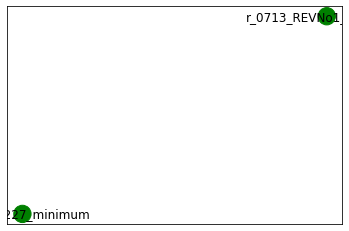

In [346]:
draw_network(network_df["network"][20])